# Quixeramobim - Station: 82586

### Latitude: -5.17, Longitude: -39.29

---
## Data: 
### Collected by Instituto Nacional de Meteorologia (INMET)
### 2015-01-01 a 2020-01-01
### 1827 entries
### Total daily Solar Irradiation by area (KJ/m²)
---

##### To install "folium" library, if necessary.

!pip install folium

or 

conda install folium

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math

from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
import pymannkendall as mk

import folium as fl 

import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

warnings.filterwarnings("ignore")


%matplotlib inline


2022-10-27 00:42:58.779125: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-27 00:42:58.782149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 00:42:58.782162: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Interesting to show the INMET Quixeramobim collection point.
mapa = fl.Map(location=[-6.092, -39.206], 
              tiles ='Stamen Terrain')

mapa.add_child(fl.LatLngPopup())

fl.Marker([-5.17, -39.29], 
         popup='<i>Station Quixeramobim-CE</i>',
         tooltip='Click!').add_to(mapa)
mapFrame = 'output.html'
mapa.save(mapFrame) # To save one .html
mapa # To show in output cell

In [4]:
dataFrame = pd.read_csv('https://raw.githubusercontent.com/Raul-rx7/LSTM/master/Quixeramobim/quixeramobim.csv')
dataFrame['date'] = pd.to_datetime(dataFrame['date'], format='%Y-%m-%d', errors='ignore')
dataFrame.set_index('date', inplace=True)
df = dataFrame[5479:] # 2015 to 2020
#df = df[3653:].values # 2010 to 2020
df = df.astype('float32')
#df = dataFrame
trainSize = int(len(df)*0.80)
trainSetDf, testSetDf = df[0:trainSize], df[trainSize:]  # DataFrames
trainSet, testSet = df[0:trainSize].values, df[trainSize:].values # Just Values

trainDate, testDate = dataFrame[5479:].index[0:trainSize], dataFrame[5479:].index[trainSize:]

print(df.info())
print(df.head())
print(df.tail())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2015-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rad     1827 non-null   float32
dtypes: float32(1)
memory usage: 21.4 KB
None
             rad
date            
2015-01-01  10.1
2015-01-02   7.9
2015-01-03   5.5
2015-01-04   3.4
2015-01-05   7.9
             rad
date            
2019-12-28  10.4
2019-12-29   9.2
2019-12-30   5.0
2019-12-31   1.6
2020-01-01   3.7


## Pre-processing
### Decomposing the time series using the **statsmodels** library.
It may interesting to see the time series decompositions: Trend, Seasonality and Resid.

### Test of Normality
This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis to produce an omnibus test of normality.

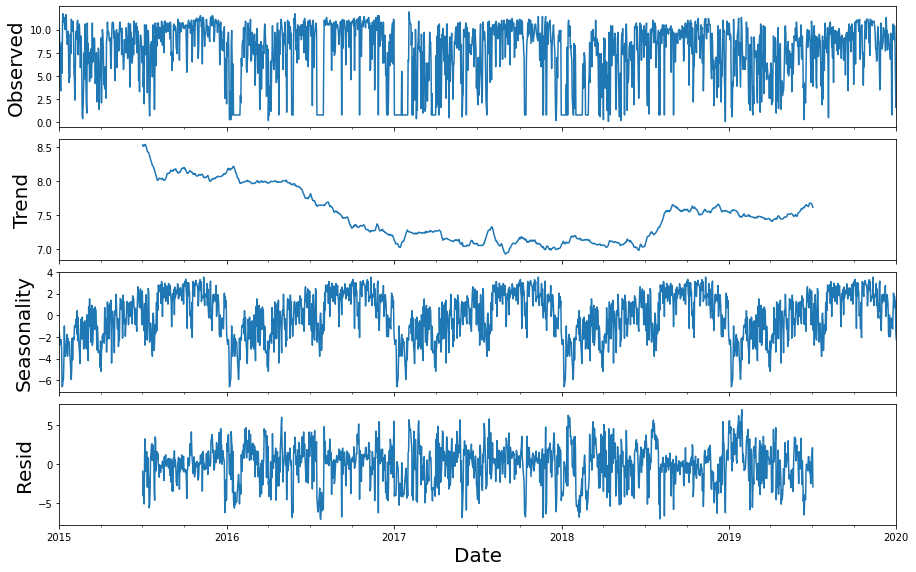

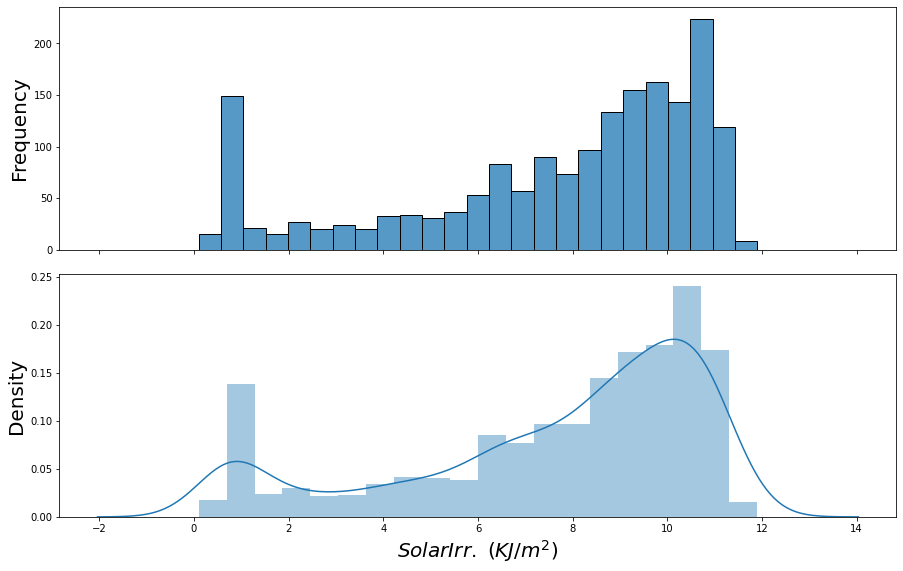

Normality Test:
Stat_test = 210.20694186266368
P_value = 2.260177491798138e-46
The significance interval is greater or equal then P-Value?  True


In [5]:
decompose= seasonal_decompose(df['rad'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,8))
decompose.observed.plot(ax=axes[0], legend=False, color='tab:blue')
axes[0].set_ylabel('Observed', fontsize=20)
decompose.trend.plot(ax=axes[1], legend=False, color='tab:blue')
axes[1].set_ylabel('Trend', fontsize=20)
decompose.seasonal.plot(ax=axes[2], legend=False, color='tab:blue')
axes[2].set_ylabel('Seasonality', fontsize=20)
decompose.resid.plot(ax=axes[3], legend=False, color='tab:blue')
axes[3].set_ylabel('Resid', fontsize=20)
axes[3].set_xlabel('Date', fontsize=20)
plt.subplots_adjust(wspace=0.0, hspace=0.1, bottom=0.08, top=0.98)
plt.show()
plt.close()

print()

# Histplot and Probability Density. Using the Matplotlib and Seaborn libraries.
# Default Significance from Seaborn pack is equivalent to 5%.
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,8))
sns.histplot(df.rad, color='tab:blue', bins=25, ax=axs[0])
axs[0].set_ylabel('Frequency', fontsize=20)

sns.distplot(df['rad'], kde=True, color='tab:blue', bins=20, ax=axs[1])
axs[1].set_xlabel(r'$Solar Irr.\ (KJ/m^{2})$', fontsize=20) # You can pass LaTeX commands.
axs[1].set_ylabel('Density', fontsize=20)
plt.subplots_adjust(wspace=0.0, hspace=0.1, bottom=0.095, top=0.98) # To ajust the plot.
plt.show()
plt.close()

# Normality Test:
signifi = 0.05
stat_test, p_value = normaltest(df.rad)
print("Normality Test:\nStat_test = {}\nP_value = {}".format(stat_test, p_value))

if(signifi >= p_value):
  print("The significance interval is greater or equal then P-Value? ", signifi >= p_value)


So, we are rejecting the null hypotesis. It doesn't come from a normal distribution.

### Augmented Dickey-Fuller (ADF) test and Mann-Kendall (MK) test
- ADF Test: An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

- MK Test: Is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time.


In [6]:
# ADF and MK test

## Stationarity test (ADF) using the original data
result = adfuller(df['rad'].dropna())
print(f"\nTest ADF: {result[0]}")
print(f"p-valor: {result[1]}")

## Stationarity test with a 1ª diff
resultd = adfuller(df['rad'].diff().dropna())
print("\nTest ADF with 1 diff:")
print(f"Test ADF: {resultd[0]}")
print(f"p-valor: {resultd[1]}")

'''If a number is given, the confidence intervals 
for the given level are returned. For instance if 
alpha=0.05, 95 % confidence intervals are returned 
where the standard deviation is computed according to Bartlett's 
formula. If None, no confidence intervals are plotted.'''

print(f"\nTest MK\n{mk.original_test(df, alpha=0.05)}")
print(f"\nTest MK diff\n{mk.original_test(df.rad.diff().dropna(), alpha=0.05)}")


Test ADF: -5.653765131219432
p-valor: 9.726015106467698e-07

Test ADF with 1 diff:
Test ADF: -14.525388651145601
p-valor: 5.439085343237295e-27

Test MK
Mann_Kendall_Test(trend='decreasing', h=True, p=0.01574626866531159, z=-2.4147440870784593, Tau=-0.037685898093043915, s=-62862.0, var_s=677673258.6666666, slope=-0.00019802055736579518, intercept=8.880792578140108)

Test MK diff
Mann_Kendall_Test(trend='no trend', h=False, p=0.936904811040776, z=-0.07916069028650598, Tau=-0.0012363276268211076, s=-2060.0, var_s=676540107.3333334, slope=0.0, intercept=0.0)


- ADF Test Result: Rejecting the null hypotesis, that means we are working with a stationary data;

- MK Test Result: From this MK test result, we can say that there is a significant trend in this dataset 'Quixaramobim'. Because the p-value is smaller than alpha = 0.05 and h=True. Thus, there is significant trend in the time series data. The trend is decreasing and the value/slope is -1.95e-4.

## Function to split the Dataset
- Create the vectors X and Y;
- LoopBack variable defines the length of Y predictions.

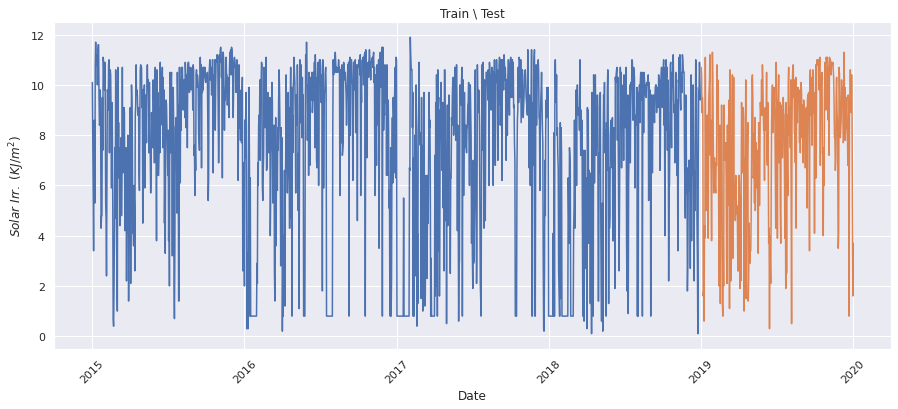

In [7]:
sns.set_theme()
fig = plt.figure(figsize=(15, 6))
plt.plot(trainSetDf)
plt.plot(testSetDf)
plt.title('Train \ Test')
plt.xlabel('Date')
plt.ylabel(r'$Solar \ Irr.\ (KJ/m^{2})$')
plt.xticks(rotation=45);

Okay. We can apply some methods to make models and forecasts, but here we will only use the LSTM model.

In [8]:
# DataSet to put in the LSTM cell
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def do_lstm_model(df, 
                  Y, 
                  look_back = 2, 
                  Epocas = 2,
                  train_fraction = 0.80,
                  LR = 0.1):

    # Setting a fixed random seed 
    np.random.seed(7)

    # Setting data
    dataset = df[Y].values
    dataset = dataset.astype('float32')

    # Normalizing to make the calculation easier (between 0 and 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    # Splitting Train-Test
    trainSize = int(len(dataset) * train_fraction)
    testSize = len(dataset) - trainSize
    Treino, Teste = dataset[0:trainSize,:], dataset[trainSize:len(dataset),:]

    # Reshape for X=t e Y=t+1
    look_back = look_back
    TreinoX, TreinoY = create_dataset(Treino, look_back)
    testX, testY = create_dataset(Teste, look_back)
    TreinoX = np.reshape(TreinoX, (TreinoX.shape[0], 1, TreinoX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
    # Call the LSTM and train the network.
    batch_size = 45
    model = Sequential()
  
    model.add(LSTM(units=150, input_shape=(1, look_back), return_sequences=True))
    model.add(Dropout(0.20))

    model.add(LSTM(units=70, return_sequences=True))
    model.add(Dropout(0.20))

    model.add(LSTM(units=30, return_sequences=True))
    model.add(Dropout(0.25))

    model.add(LSTM(units=10))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation= 'relu'))

    # Its possible to modify the function activation parameters as well:
    
    '''RMSSprop=tf.keras.optimizers.RMSprop(
        learning_rate=0.001,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        name="RMSprop")'''
    
    '''initial_learning_rate = LR
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)'''

    opt1 = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss='mean_squared_error', optimizer=opt1, metrics=['mean_absolute_error'])
    model.summary() # Uncomment if you want to see the summary network. 
    
    # Fit network
    history = model.fit(TreinoX, 
              TreinoY, 
              epochs = Epocas, 
              batch_size = 45,
              validation_data=(testX, testY), 
              verbose = 0)
  
    # Data predict
    trainPredict = model.predict(TreinoX)
    testPredict = model.predict(testX)

    # Comeback to original scale to Plot
    trainPredict = scaler.inverse_transform(trainPredict)
    TreinoY = scaler.inverse_transform([TreinoY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    resid = np.array(testY - testPredict)
    print("><"*15)
    # Calculation of RMSE and present the result
    trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.4f RMSE' % (testScore))
    testScore2 = mean_squared_error(testY[0], testPredict[:,0])
    print('Test Score 2: %.4f MSE' % (testScore2))


    # Criando vetores de train e teste preditos para plotar
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Plot the History (i.e. cost curve in training and predict steps)
    plt.figure(figsize=(15, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig('history.png')
    plt.show()
    plt.close()

    # Resid Histogram
    fig = plt.figure(figsize=(10, 5))
    sns.distplot(resid, bins=35)
    plt.show()
    plt.close()
    
    # Results Plotting
    fig = plt.figure(figsize=(15,5))
    plt.plot(testY[0], color='blue', label='Real Value')
    plt.plot(testPredict[:,0], color='orange', label='Forecasts')
    plt.xlabel('date')
    plt.ylabel(r'$Solar \ Irr.\ (KJ/m^{2})$ values')
    plt.legend(loc=1)
    plt.show()
    plt.close();


    return

2022-10-27 00:43:51.296156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 00:43:51.296177: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 00:43:51.296193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-27 00:43:51.296392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 150)            102600    
                                                                 
 dropout (Dropout)           (None, 1, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 70)             61880     
                                                                 
 dropout_1 (Dropout)         (None, 1, 70)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 30)             12120     
                                                                 
 dropout_2 (Dropout)         (None, 1, 30)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                1

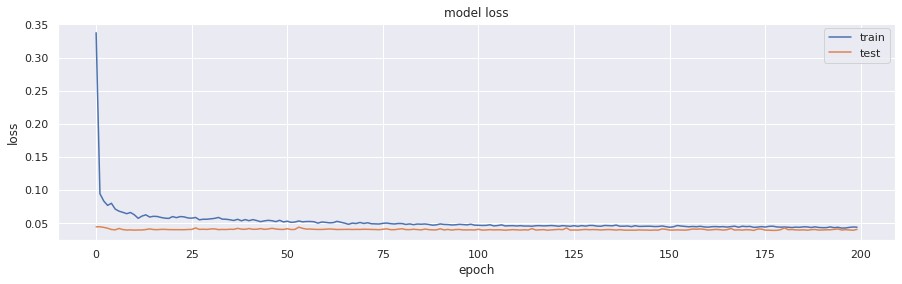

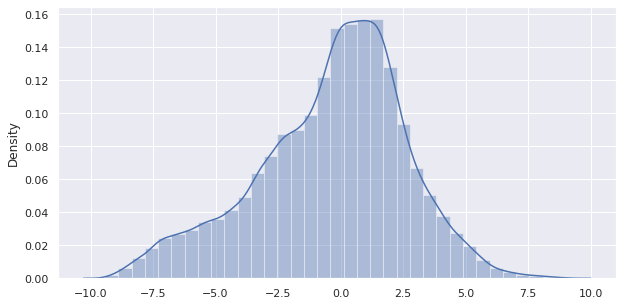

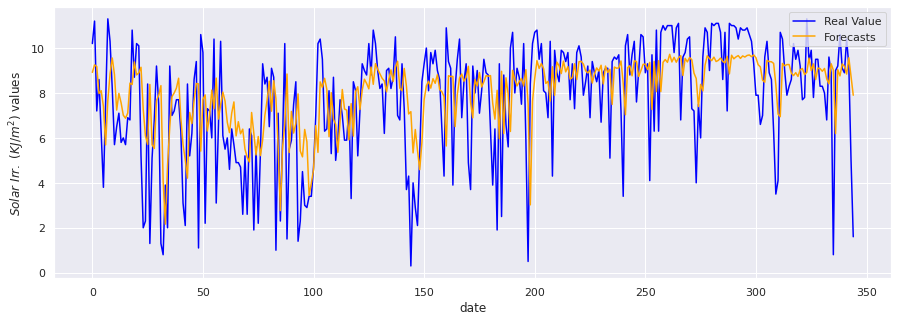

In [9]:
do_lstm_model(df,
              Y='rad',
              look_back = 20, 
              Epocas = 200,
              train_fraction = 0.80,
              LR = 0.001)

The resid plot can be interesting to see how good our predictions are (i.e. how close it is to a normal distribution). You can simply apply a **normal test** for a residual data, get the mean and variance, and come to a conlusion about your model.

Furthermore you can change the parameters and make some predictions using this simple code. 

Okay. Done. Now just try it for yourself ;D